# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow opencv-python matplotlib

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)


In [3]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
altair                        4.2.0
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bi

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [12]:
import cv2
import imghdr #imghdr checks file extension for our images

In [13]:
data_dir = 'data' 

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [22]:
len(os.listdir(os.path.join(data_dir,'happy')))

153

In [24]:
for image_class in os.listdir(data_dir): #going into our dir (happy or sad)
    for image in os.listdir(os.path.join(data_dir, image_class)):#going through every image in the directory
        image_path = os.path.join(data_dir, image_class, image)#grabing every image individually
        try: 
            img = cv2.imread(image_path)#opens up the image into numpy array 
            tip = imghdr.what(image_path)#checks the extension
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [30]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [78]:
import numpy as np
from matplotlib import pyplot as plt

In [79]:
data = tf.keras.utils.image_dataset_from_directory('data')#builts the datasets on its own, and also perform some preprocessing and even resizes our images

Found 305 files belonging to 2 classes.


In [80]:
data_iterator = data.as_numpy_iterator()#converting our data into numpy iterator

In [81]:
batch = data_iterator.next()

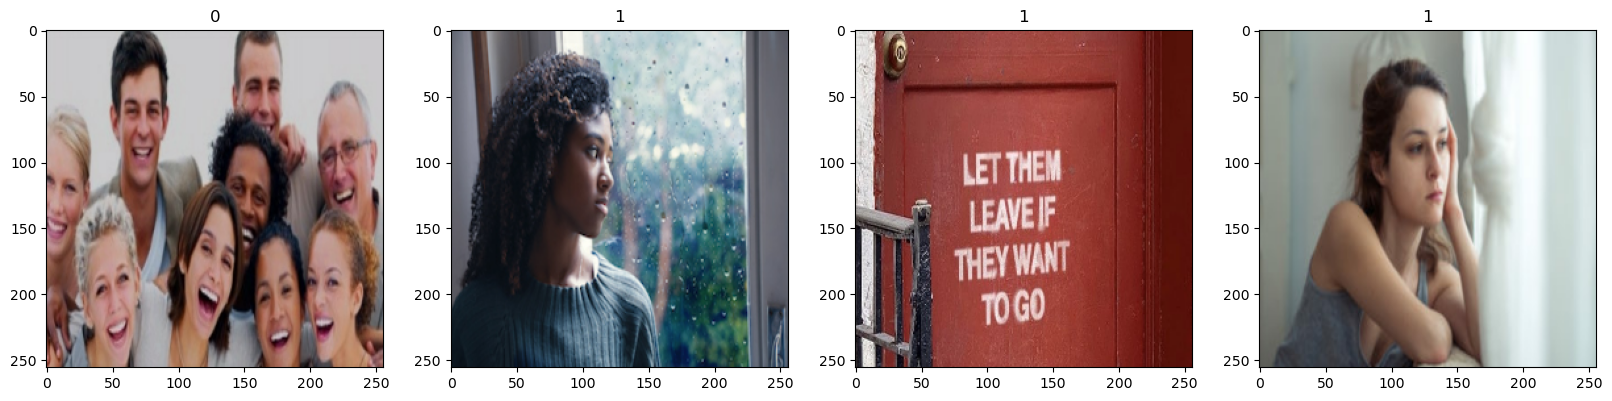

In [82]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
    #here 0--> happy & 1--> sad

# 4. Scale Data

In [83]:
data = data.map(lambda x,y: (x/255, y))#transforming the data to be between 0 & 1


In [84]:
scaled_iterator=data.as_numpy_iterator()

In [85]:
batch=scaled_iterator.next()

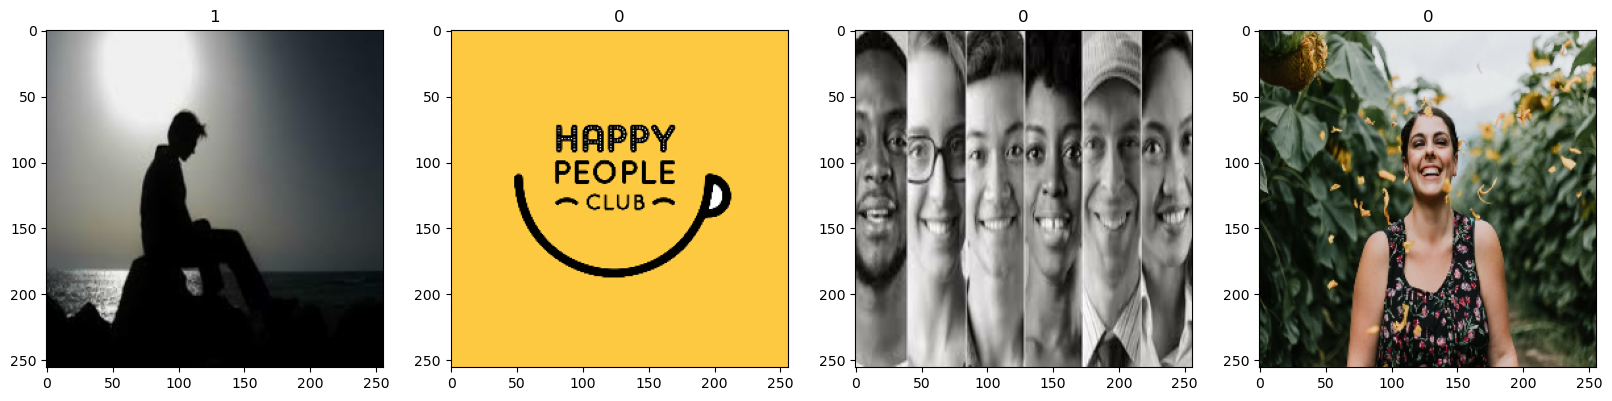

In [86]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    
    #here 0--> happy & 1--> sad

In [89]:
batch[0].min()

0.0

# 5. Split Data

In [49]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [56]:
train_size+val_size+test_size

10

In [119]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

#take - how much data we are going to take in a partition
#skip - skip the batches already used in partition

# 6. Build Deep Learning Model

In [120]:
from tensorflow.keras.models import Sequential
#sequential is best if have one input and one output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [130]:
model = Sequential()

In [131]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#16-filters,(3,3)pixel size , and move by 1 straid, first layer should have input layer, relu-positive value remains unchanged but changes any negative value to 0.
#activation makes our model very powerful, also reshapes our output
model.add(MaxPooling2D())
#maxpooling condenses our information down to half
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#dense are fully connected layer
#model.add(Dense(1, activation='sigmoid')) --> give single value
#sigmoid function converts any output between 0 & 1
#0-->happy
#1-->sad

In [132]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [133]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 30, 30, 16)      

# 7. Train

In [134]:
logdir='logs'

In [135]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [136]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
#epochs- how long are we training the data the model
#then we pass validation to check how well is our model performing
#callback is like checkpoint
#ideally losses should decrease and accuracy should increase gradually

Epoch 1/20
7/7 [==============================] - 21s 2s/step - loss: 1.1237 - accuracy: 0.4777 - val_loss: 0.6799 - val_accuracy: 0.5312
Epoch 2/20
7/7 [==============================] - 16s 2s/step - loss: 0.6757 - accuracy: 0.5848 - val_loss: 0.6468 - val_accuracy: 0.7188
Epoch 3/20
7/7 [==============================] - 17s 2s/step - loss: 0.6301 - accuracy: 0.6607 - val_loss: 0.5439 - val_accuracy: 0.7344
Epoch 4/20
7/7 [==============================] - 16s 2s/step - loss: 0.5575 - accuracy: 0.7545 - val_loss: 0.5492 - val_accuracy: 0.6562
Epoch 5/20
7/7 [==============================] - 16s 2s/step - loss: 0.5173 - accuracy: 0.7634 - val_loss: 0.4110 - val_accuracy: 0.8594
Epoch 6/20
7/7 [==============================] - 17s 2s/step - loss: 0.3493 - accuracy: 0.8795 - val_loss: 0.3765 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.3671 - accuracy: 0.7857 - val_loss: 0.2595 - val_accuracy: 0.9688
Epoch 8/20
7/7 [==================

# 8. Plot Performance

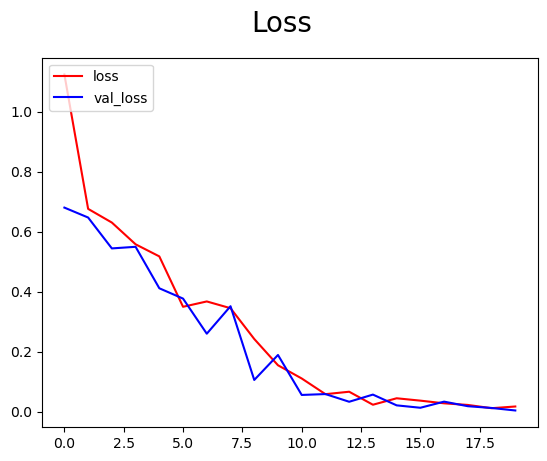

In [140]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

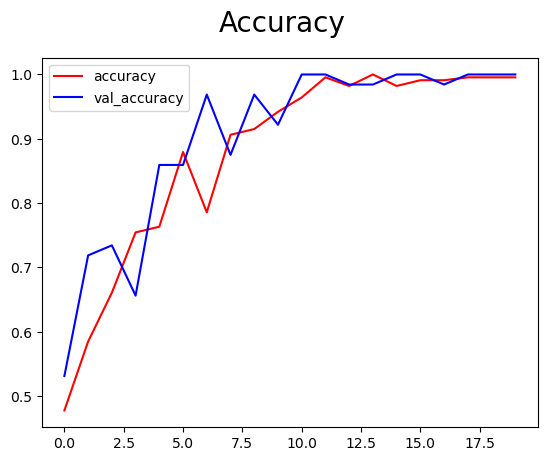

In [139]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [145]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [146]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [148]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    #we are making our prediction
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 203ms/step


In [149]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [180]:
import cv2

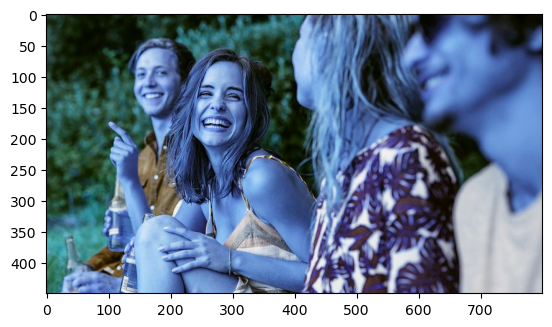

In [209]:
img = cv2.imread('happytest3.jpg')
plt.imshow(img)
plt.show()

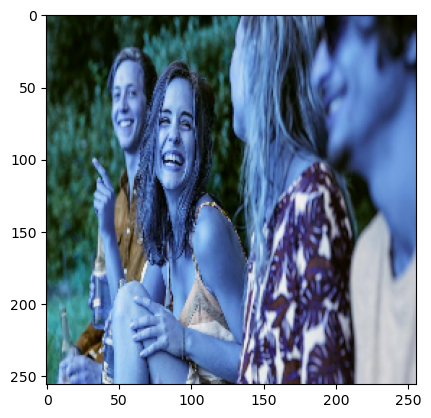

In [210]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [211]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 29ms/step


In [212]:
yhat

array([[0.17201799]], dtype=float32)

In [213]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [192]:
from tensorflow.keras.models import load_model

In [193]:
model.save(os.path.join('models','imageclassifier.h5'))

In [196]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [197]:
yhatnew=new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 179ms/step


In [198]:
if yhatnew > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
